# A short description of libatrous

My "A trous" wavelet library with Python 2 bindings, which can be used to filter 1-D, 2-D and 3-D arrays.

There are a few (hopefully useful) tricks I have implemented in the library:

* The library uses separable kernels and OpenMP for speed improvements.
* Image border artifacts are greatly reduced by using mirrored edges.
* Rectangular shaped voxels are taken into account by using re-gridding (interpolated nearest neighbour positions).

## Here is enough code to get people started:

In [1]:
import libatrous
import numpy as np

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['figure.figsize'] = (20.0, 20.0)

import scipy.misc

## Kernels:
A few useful kernels are available in libatrous. But, any separable convolution kernel can be passed to the libatrous.iterscale as a 1-D array of dtype np.float32.

In [2]:
libatrous.get_names()

['Linear 3x3',
 'B3 Spline 5x5',
 'Cubic alpha=-1',
 'Cubic alpha=-0.5',
 'CDF 9/7 (JPEG 2000)',
 'Gaussian 5x5',
 'Linear 5x5']

In [3]:
kernel = libatrous.get_kernel(0)
kernel

array([ 0.25,  0.5 ,  0.25], dtype=float32)

## Only one function needed:

Calculating the individual scales and residual low pass is an iterative process. For this, only one (optimised) function is required:

**libatrous.iterscale(lowpass, kernel, scale_index)**
* lowpass: The input array to process
* kernel: The 1-D convolution kernel array
* scale_index: The 0-indexed scale index
* **output:** band-pass and low-pass, the sum of which is the input array



With large input arrays, the memory required to store every single scale (and residual) can quickly become an issue, especially since we are malloc-ating the required memory as a contiguous block of memory (don't do that!).

Here is how we would use libatrous.iterscale to create a python list of arrays, where only the individual scales (and residual) are contiguous, not the total amount of memory required to store the array. This is only marginally better, but may not overflow the system if a contiguous block cannot be allocated.

The scenario for this is when we want to pre-compute a bunch of scales, up to a pre-defined largest scale (slow), and then interactively add any of the scales and / or residual together to generate the output array (fast).

In [4]:
def get_scales(input_array, nscales, kernel):
    scales = []
    lowpass = input_array.astype(np.float32)
    for i in range(nscales):
        bandpass,lowpass = libatrous.iterscale(lowpass,kernel,i)
        scales.append(bandpass)
    
    scales.append(lowpass)
    return scales

**However,** we often only need the resulting band pass filter between scale1 and scale2 (0-indexed, scale2 excluded), in which case there is no need to allocate memory for the individual scales, only for the output image.

In [5]:
def get_bandpass(input_array, scale1, scale2, kernel, lowpass = False):
    output = np.zeros(input_array.shape, np.float32)
    lowpass = input_array.astype(np.float32)
    for i in range(scale2+1):
        bandpass,lowpass = libatrous.iterscale(lowpass,kernel,i)
        if i >= scale1:
            output += bandpass
            
    if lowpass:
        output += lowpass

    return output

**Finally,** in some cases, we may only be interested in the low-pass residual, after having discarded *N* scales.

In [6]:
def get_lowpass(input_array, n_discarded, kernel):
    lowpass = input_array.astype(np.float32)
    for i in range(n_discarded):
        bandpass,lowpass = libatrous.iterscale(lowpass,kernel,i)

    return lowpass

## Example:

The example below shows the scipy "ascent" image split into multiple scales and residual, using kernel filters stored in libatrous. Of course, any kernel can be passed to libatrous.iterscale (as a np.float32 1-D array).

Kernel Linear 3x3 coefficients: [ 0.25  0.5   0.25]
Kernel B3 Spline 5x5 coefficients: [ 0.0625  0.25    0.375   0.25    0.0625]
Kernel Cubic alpha=-1 coefficients: [-0.0625  0.      0.3125  0.5     0.3125  0.     -0.0625]
Kernel Cubic alpha=-0.5 coefficients: [-0.03125  0.       0.28125  0.5      0.28125  0.      -0.03125]
Kernel CDF 9/7 (JPEG 2000) coefficients: [ 0.0267     -0.0168     -0.0782      0.26679999  0.60290003  0.26679999
 -0.0782     -0.0168      0.0267    ]
Kernel Gaussian 5x5 coefficients: [ 0.06136     0.24477001  0.38773999  0.24477001  0.06136   ]
Kernel Linear 5x5 coefficients: [ 0.1         0.2         0.40000001  0.2         0.1       ]


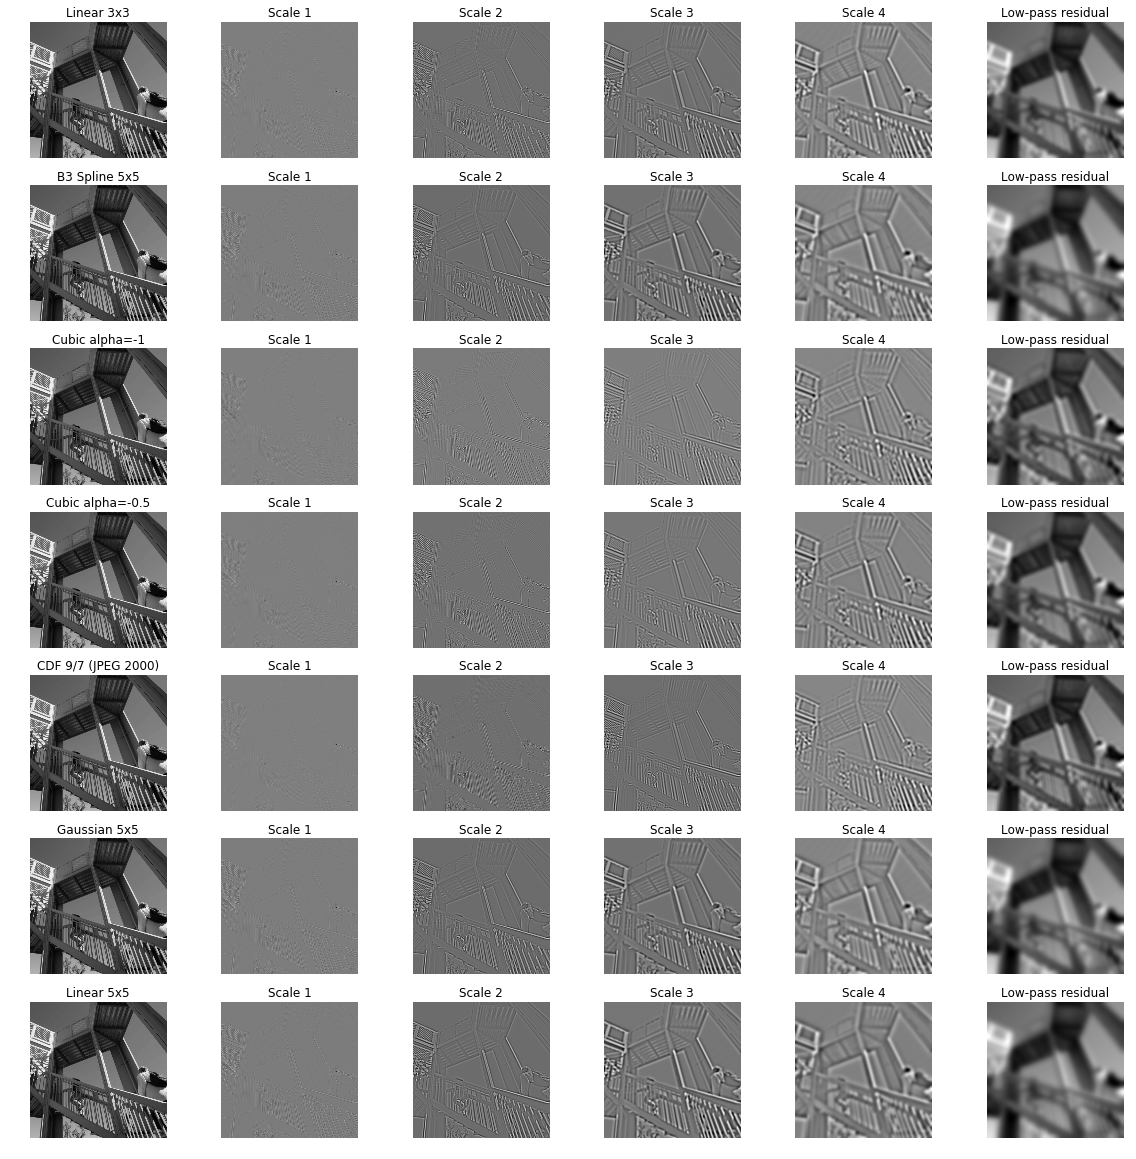

In [7]:
nscales = 4

kernel_names = libatrous.get_names()
n_kernel = len(kernel_names)

fig, subplots = plt.subplots(n_kernel,nscales+2)

ascent = scipy.misc.ascent()

for j in range(n_kernel):

    kernel = libatrous.get_kernel(j)
    print("Kernel %s coefficients: %s" % (kernel_names[j],str(kernel)))

    scales = [ascent]+get_scales(ascent,nscales,kernel)

    for i in range(nscales+2):
        if i == 0:
            title = kernel_names[j]
        elif i == nscales+1:
            title = "Low-pass residual"
        else:
            title = "Scale %d" % (i)
        
        ax = subplots[j][i]
        ax.imshow(scales[i],cmap='gray')
        ax.set_axis_off()
        ax.set_title(title)

## Working with 3-D arrays, a small caveat:

By using [separable kernels](https://en.wikipedia.org/wiki/Separable_filter), input arrays can in principle be of any dimension. However, only 1-D, 2-D and 3-D arrays are recognised for now.

When using libatrous to filter 3-D microscopy images, voxels often do not have the same dimension in X,Y and Z. This needs to be accounted for to avoid over-emphasising any of the X,Y or Z directions.

Voxel dimensions are input using the following command (for a 0.24,0.24,1.00um voxel):

In [8]:
libatrous.set_grid(0.24,0.24,1)

This is done during calculations by considering the (equivalent) nearest neigbour at the requested position.

Also, when working with 2-D+time stacks, we may want to either apply a filter in the Z (time) direction only, or apply the filter in the X and Y directions for each frame in the stack but not apply the filter in the Z direction.

I added the **enable_conv()** function to control which dimensions the separable filter kernel is applied to.

In the first case and before applying the filter, use:

In [9]:
libatrous.enable_conv(0,0,1)

And in the second case:

In [10]:
libatrous.enable_conv(1,1,0)

# A trous wavelet with edge awareness

my implementation closely matches [1], however I changed my edge stopping function to fit with the separable kernel calculation strategy, as per [2].

Basically equation (3) in [1], 

\begin{align}
G_{\sigma_r} ( a^i_m - a^i_n) = exp \left( - \frac{\|a^i_m - a^i_n\|^2}{\sigma_r^2}\right) \\
\end{align}

is replaced by 

\begin{align}
G_{\sigma_r} ( a^i_m - a^i_n) = exp \left( - \frac{\|a^i_m - a^i_n\|}{\sigma_r}\right) \\
\end{align}

according to the code described in [2] and applied for each dimension as part of the kernel convolution calculation. The normalisation factor $W_a$ in equation (4) is also calculated and applied separately for each dimension.

Be aware in [1] that $\sigma_r$ is a fraction of the max value of the input image (as far as I understand).

$\alpha$ is the shrinkage rate of $\sigma_r$.

Also, [1] uses the B3 Spline 5x5 kernel coefficients, as in libatrous.get_kernel(1).

## References
* [1] Baojun Qi, Tao Wu, and Hangen He. [A Novel Edge-Aware À-Trous Filter For Single Image Dehazing](http://ieeexplore.ieee.org/document/6221770/). 2012 IEEE International Conference on Information Science and Technology
* [2] Holger Dammertz, Daniel Sewtz, Johannes Hanika, Hendrik P.A. Lensch [Edge-Avoiding À-Trous Wavelet Transform for fast Global Illumination Filtering](https://jo.dreggn.org/home/2010_atrous.pdf). HPG 2010

Let's modify the previous iterative scale calculation to add the stopping function and use an optimised libatrous function that applies it and the shrinkage rate. The new get_scales_ea() takes the following arguments:
* input_array is the 1-D, 2-D or 3-D data to filter
* nscales is the number of scales to calculate
* kernel is the kernel array
* sigmar is a fraction of the maximum intensity value (try 0.2)
* alpha is the shrink rate of $\sigma_r$, (try 2)

At each step, the stopping function map (dmap) is calculated by get_dmap() for intensity differences between 0 and max_input. To calculate dmap, the 0-indexed scale, number of scales, sigmar, alpha and max_input need to be passed as parameters.

In [11]:
def get_scales_ea(input_array, nscales, kernel, sigmar, alpha):
    scales = []
    max_input = int(np.amax(input_array))
    sigmar = sigmar * max_input
    lowpass = input_array.astype(np.float32)
    for i in range(nscales):
        dmap = libatrous.get_dmap(i,nscales,sigmar,alpha,max_input)
        bandpass,lowpass = libatrous.iterscale_ea(lowpass,kernel,dmap,i)
        scales.append(bandpass)
    
    scales.append(lowpass)
    return scales

Let's try with the [cameraman picture](https://raw.githubusercontent.com/antimatter15/cameraman/master/cameraman.png) as in [1].
![Cameraman](https://raw.githubusercontent.com/antimatter15/cameraman/master/cameraman.png)

In [12]:
import scipy.ndimage
cameraman = scipy.ndimage.imread("cameraman.png")
print cameraman.shape

(256, 256)


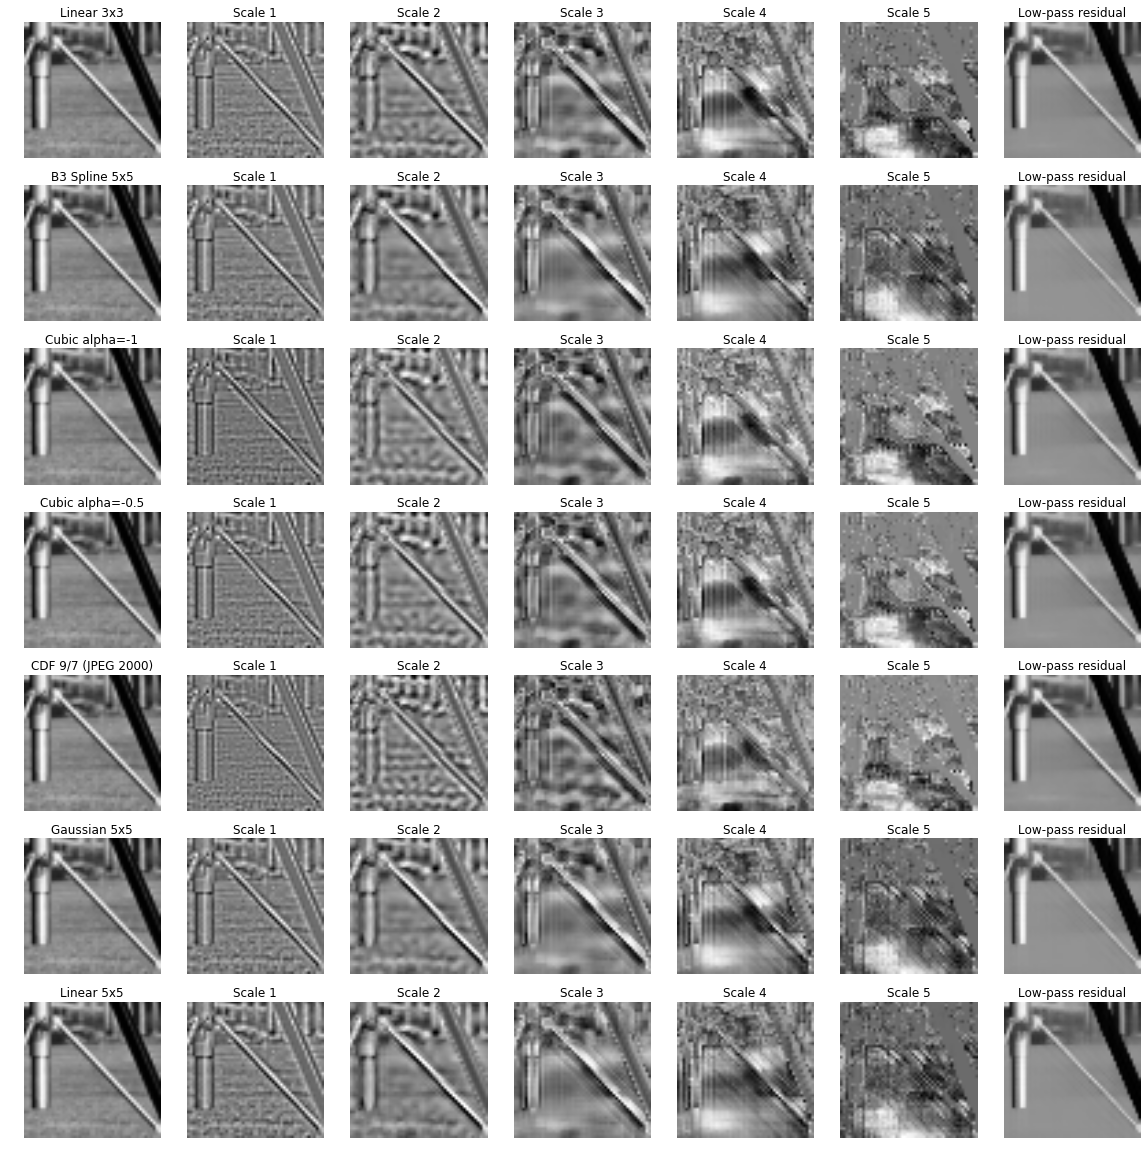

In [13]:
nscales = 5

kernel_names = libatrous.get_names()
n_kernel = len(kernel_names)

fig, subplots = plt.subplots(n_kernel,nscales+2)

sigmar = 0.2
alpha = 2

for j in range(n_kernel):

    kernel = libatrous.get_kernel(j)
    scales = [cameraman]+get_scales_ea(cameraman,nscales,kernel,sigmar,alpha)

    for i in range(nscales+2):
        if i == 0:
            title = kernel_names[j]
        elif i == nscales+1:
            title = "Low-pass residual"
        else:
            title = "Scale %d" % (i)
        
        ax = subplots[j][i]
        ax.imshow(scales[i][160:210,128:178],cmap='gray')
        ax.set_axis_off()
        ax.set_title(title)

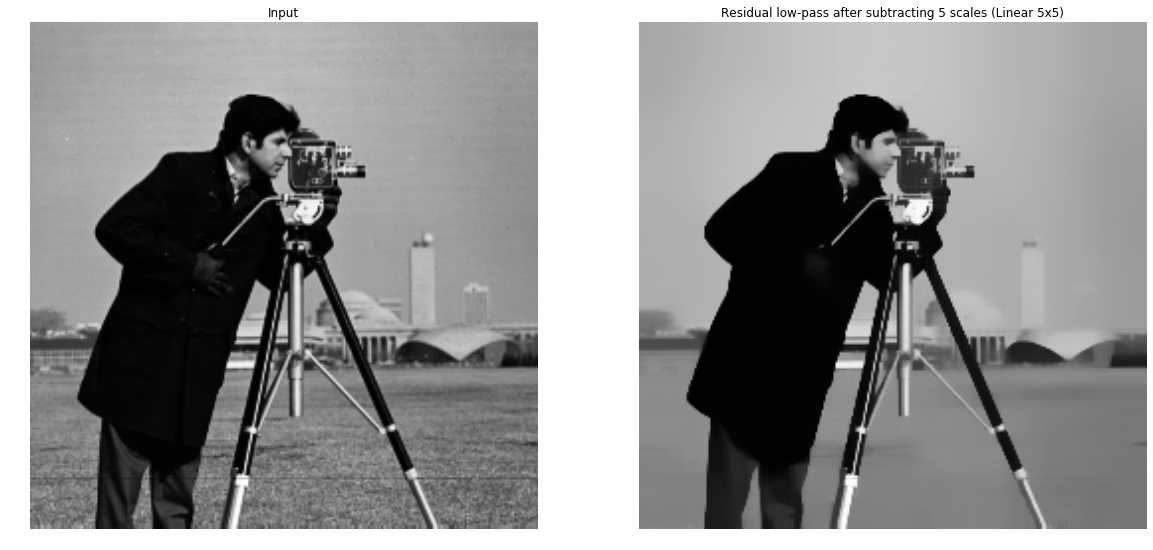

In [14]:
fig, subplots = plt.subplots(1,2)

ax = subplots[0]
ax.imshow(cameraman,cmap='gray')
ax.set_axis_off()
ax.set_title("Input")

ax = subplots[1]
ax.imshow(scales[-1],cmap='gray')
ax.set_axis_off()
_ = ax.set_title("Residual low-pass after subtracting %d scales (%s)" % (nscales,kernel_names[-1]))

# TODO

Add some bound checks when using the dmap array. Maybe add a set_maxvalue() function to libatrous (poor attempt but better than nothing).